# Read Data Sample

In [1]:
import pandas as pd
import numpy as np
import os
import time
from collections import namedtuple
pd.set_option("display.max_rows",35)
%matplotlib inline

In [2]:
%%bash
rm dataset/scores/tf_dense_only_nsl_kdd_scores_all.pkl

rm: cannot remove 'dataset/scores/tf_dense_only_nsl_kdd_scores_all.pkl': No such file or directory


In [3]:
class dataset:
    kdd_train_2labels = pd.read_pickle("dataset/kdd_train_2labels.pkl")
    kdd_test_2labels = pd.read_pickle("dataset/kdd_test_2labels.pkl")
    kdd_test__2labels = pd.read_pickle("dataset/kdd_test__2labels.pkl")
    
    kdd_train_5labels = pd.read_pickle("dataset/kdd_train_5labels.pkl")
    kdd_test_5labels = pd.read_pickle("dataset/kdd_test_5labels.pkl")
    

In [4]:
dataset.kdd_train_2labels.shape

(125973, 124)

In [5]:
dataset.kdd_test_2labels.shape

(22544, 124)

In [6]:
from sklearn import model_selection as ms
from sklearn import preprocessing as pp

class preprocess:
    
    output_columns_2labels = ['is_Normal','is_Attack']
    
    x_input = dataset.kdd_train_2labels.drop(output_columns_2labels, axis = 1)
    y_output = dataset.kdd_train_2labels.loc[:,output_columns_2labels]

    x_test_input = dataset.kdd_test_2labels.drop(output_columns_2labels, axis = 1)
    y_test = dataset.kdd_test_2labels.loc[:,output_columns_2labels]
    
    x_test__input = dataset.kdd_test__2labels.drop(output_columns_2labels, axis = 1)
    y_test_ = dataset.kdd_test__2labels.loc[:,output_columns_2labels]

    ss = pp.StandardScaler()

    x_train = ss.fit_transform(x_input)
    x_test = ss.transform(x_test_input)
    x_test_ = ss.transform(x_test__input)

    y_train = y_output.values
    y_test = y_test.values
    y_test_ = y_test_.values

    
preprocess.x_train.std()

0.99589320646770185

In [7]:
import tensorflow as tf
from tensorflow.contrib.legacy_seq2seq.python.ops.seq2seq import basic_rnn_seq2seq
from tensorflow.contrib.rnn import RNNCell, LSTMCell, MultiRNNCell


In [8]:
class network(object):
    
    input_dim = 122
    classes = 2
    hidden_encoder_dim = 122
    hidden_layers = 1
    latent_dim = 10

    hidden_decoder_dim = 122
    lam = 0.01
    
    def __init__(self, classes, hidden_layers, num_of_features):
        self.classes = classes
        self.hidden_layers = hidden_layers
        self.latent_dim = num_of_features
            
    def build_layers(self):
        tf.reset_default_graph()
        #learning_rate = tf.Variable(initial_value=0.001)

        input_dim = self.input_dim
        classes = self.classes
        hidden_encoder_dim = self.hidden_encoder_dim
        hidden_layers = self.hidden_layers
        latent_dim = self.latent_dim
        hidden_decoder_dim = self.hidden_decoder_dim
        lam = self.lam
        
        with tf.variable_scope("Input"):
            self.x_input = tf.placeholder("float", shape=[None, 1, input_dim])
            self.y_input_ = tf.placeholder("float", shape=[None, 1, classes])
            self.keep_prob = tf.placeholder("float")
            self.lr = tf.placeholder("float")
            self.x_list = tf.unstack(self.x_input, axis= 1)
            self.y_list_ = tf.unstack(self.y_input_, axis = 1)
            self.y_ = self.y_list_[0]
            
            #GO = tf.fill((tf.shape(self.x)[0], 1), 0.5)
            
            #y_with_GO = tf.stack([self.y_, GO])
            
        with tf.variable_scope("lstm"):
            multi_cell = MultiRNNCell([LSTMCell(input_dim) for i in range(hidden_layers)] )
            
            self.y, states = basic_rnn_seq2seq(self.x_list, self.y_list_, multi_cell)
            #self.y = tf.slice(self.y, [0, 0], [-1,2])
            
            #self.out = tf.squeeze(self.y)
            
            #self.y = tf.layers.dense(self.y[0], classes, activation = None)
            
            self.y = tf.slice(self.y[0], [0, 0], [-1,2])
            
        with tf.variable_scope("Loss"):
            
            self.regularized_loss = tf.losses.mean_squared_error(self.y_, self.y)
            correct_prediction = tf.equal(tf.argmax(self.y_, 1), tf.argmax(self.y, 1))
            self.tf_accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name = "Accuracy")

        with tf.variable_scope("Optimizer"):
            learning_rate=self.lr
            optimizer = tf.train.AdamOptimizer(learning_rate)
            gradients, variables = zip(*optimizer.compute_gradients(self.regularized_loss))
            gradients = [
                None if gradient is None else tf.clip_by_value(gradient, -1, 1)
                for gradient in gradients]
            self.train_op = optimizer.apply_gradients(zip(gradients, variables))
            #self.train_op = optimizer.minimize(self.regularized_loss)
            
        # add op for merging summary
        #self.summary_op = tf.summary.merge_all()
        self.pred = tf.argmax(self.y, axis = 1)
        self.actual = tf.argmax(self.y_, axis = 1)

        # add Saver ops
        self.saver = tf.train.Saver()
        

batch_iterations = 200

x_train, x_valid, y_train, y_valid, = ms.train_test_split(preprocess.x_train, 
                                                                          preprocess.y_train, 
                                                                          test_size=0.1)
batch_indices = np.array_split(np.arange(x_train.shape[0]), 
                                           batch_iterations)
                                                                          
for i in batch_indices:
    print(x_train[i,np.newaxis,:])
    print(y_train[i,np.newaxis,:])

In [9]:
import collections
import sklearn.metrics as me

class Train:    
    
    result = namedtuple("score", ['epoch', 'no_of_features','hidden_layers','train_score', 'test_score', 'f1_score', 'test_score_20', 'f1_score_20', 'time_taken'])

    predictions = {}
    predictions_ = {}

    results = []
    best_acc = 0
    best_acc_global = 0

    def train(epochs, net, h,f, lrs):
        batch_iterations = 200
        train_loss = None
        Train.best_acc = 0
        os.makedirs("dataset/tf_lstm_nsl_kdd-orig/hidden layers_{}_features count_{}".format(h,f),
                    exist_ok = True)
        with tf.Session() as sess:
            #summary_writer_train = tf.summary.FileWriter('./logs/kdd/VAE/training', graph=sess.graph)
            #summary_writer_valid = tf.summary.FileWriter('./logs/kdd/VAE/validation')

            sess.run(tf.global_variables_initializer())
            start_time = time.perf_counter()
            
            accuracy, pred_value, actual_value, y_pred = sess.run([net.tf_accuracy, 
                                                                   net.pred, 
                                                                   net.actual, net.y], 
                                                                  feed_dict={net.x_input: preprocess.x_test[:,np.newaxis,:], 
                                                                             net.y_input_: preprocess.y_test[:,np.newaxis,:], 
                                                                             net.keep_prob:1})
            
            print("Initial Accuracy, before training: {}".format(accuracy))
            
            for c, lr in enumerate(lrs):
                for epoch in range(1, (epochs+1)):
                    x_train, x_valid, y_train, y_valid, = ms.train_test_split(preprocess.x_train, 
                                                                              preprocess.y_train, 
                                                                              test_size=0.1)
                    batch_indices = np.array_split(np.arange(x_train.shape[0]), 
                                               batch_iterations)

                    for i in batch_indices:

                        _, train_loss = sess.run([net.train_op, net.regularized_loss], #net.summary_op
                                                              feed_dict={net.x_input: x_train[i,np.newaxis,:], 
                                                                         net.y_input_: y_train[i,np.newaxis,:], 
                                                                         net.keep_prob:1, net.lr:lr})
                        #summary_writer_train.add_summary(summary_str, epoch)
                        if(train_loss > 1e9):
                            print("Step {} | Training Loss: {:.6f}".format(epoch, train_loss))


                    valid_accuracy,valid_loss = sess.run([net.tf_accuracy, net.regularized_loss], #net.summary_op 
                                                          feed_dict={net.x_input: x_valid[:,np.newaxis,:], 
                                                                     net.y_input_: y_valid[:,np.newaxis,:], 
                                                                     net.keep_prob:1, net.lr:lr})
                    #summary_writer_valid.add_summary(summary_str, epoch)



                    accuracy, pred_value, actual_value, y_pred = sess.run([net.tf_accuracy, 
                                                                   net.pred, 
                                                                   net.actual, net.y], 
                                                                  feed_dict={net.x_input: preprocess.x_test[:,np.newaxis,:], 
                                                                             net.y_input_: preprocess.y_test[:,np.newaxis,:], 
                                                                             net.keep_prob:1, net.lr:lr})
                    f1_score = me.f1_score(actual_value, pred_value)
                    accuracy_, pred_value_, actual_value_, y_pred_ = sess.run([net.tf_accuracy, 
                                                                   net.pred, 
                                                                   net.actual, net.y], 
                                                                  feed_dict={net.x_input: preprocess.x_test_[:,np.newaxis,:], 
                                                                             net.y_input_: preprocess.y_test_[:,np.newaxis,:], 
                                                                             net.keep_prob:1, net.lr:lr})
                    f1_score_ = me.f1_score(actual_value_, pred_value_)
                    print("Step {} | Training Loss: {:.6f} | Train Accuracy: {:.6f} | Test Accuracy: {:.6f}, {:.6f}".format(epoch, train_loss, valid_accuracy, accuracy, accuracy_))

                    if accuracy > Train.best_acc_global:
                                Train.best_acc_global = accuracy
                                Train.pred_value = pred_value
                                Train.actual_value = actual_value
                                Train.pred_value_ = pred_value_
                                Train.actual_value_ = actual_value_
                                Train.best_parameters = "Hidden Layers:{}, Features Count:{}".format(h, f)

                    if accuracy > Train.best_acc:

                        #net.saver.save(sess, "dataset/tf_vae_only_nsl_kdd_hidden layers_{}_features count_{}".format(epochs,h,f))
                        #Train.results.append(Train.result(epochs, f, h,valid_accuracy, accuracy))
                        #curr_pred = pd.DataFrame({"Attack_prob":y_pred[:,-2], "Normal_prob":y_pred[:, -1]})
                        #Train.predictions.update({"{}_{}_{}".format(epochs,f,h):curr_pred})

                        Train.best_acc = accuracy
                        if not (np.isnan(train_loss)):
                            net.saver.save(sess, 
                                       "dataset/tf_lstm_nsl_kdd-orig/hidden layers_{}_features count_{}/model"
                                       .format(h,f), 
                                       global_step = epoch, 
                                       write_meta_graph=False)

                        curr_pred = pd.DataFrame({"Attack_prob":y_pred[:,-2], "Normal_prob":y_pred[:, -1], "Prediction":pred_value, "Actual":actual_value})
                        curr_pred_ = pd.DataFrame({"Attack_prob":y_pred_[:,-2], "Normal_prob":y_pred_[:, -1], "Prediction":pred_value_, "Actual": actual_value_})
                        Train.predictions.update({"{}_{}_{}".format((epochs+1)* (c+1),f,h):
                                                  (curr_pred,
                                                   Train.result((epochs+1)*(c+1), f, h,valid_accuracy, accuracy, f1_score, accuracy_, f1_score_, time.perf_counter() - start_time))})
                        Train.predictions_.update({"{}_{}_{}".format((epochs+1)* (c+1),f,h):
                                                  (curr_pred_,
                                                   Train.result((epochs+1)*(c+1), f, h,valid_accuracy, accuracy, f1_score, accuracy_, f1_score_, time.perf_counter() - start_time))})



            

In [10]:
import itertools

df_results = []
past_scores = []

class Hyperparameters:
#    features_arr = [2, 4, 8, 16, 32, 64, 128, 256]
#    hidden_layers_arr = [2, 4, 6, 10]

    def start_training():

        global df_results
        global past_scores
        
        Train.predictions = {}
        Train.results = []
        
        features_arr = [1] #[4, 8, 16, 32]
        hidden_layers_arr = [1, 3]

        epochs = [10]
        lrs = [1e-2, 1e-3]

        for e, h, f in itertools.product(epochs, hidden_layers_arr, features_arr):
            print("Current Layer Attributes - epochs:{} hidden layers:{} features count:{}".format(e,h,f))
            n = network(2,h,f)
            n.build_layers()
            Train.train(e, n, h,f, lrs)
            
        dict1 = {}
        dict1_ = {}
        dict2 = []
        for k, (v1, v2) in Train.predictions.items():
            dict1.update({k: v1})
            dict2.append(v2)

        for k, (v1_, v2) in Train.predictions.items():
            dict1_.update({k: v1_})

            
        Train.predictions = dict1
        Train.predictions_ = dict1_

        Train.results = dict2
        df_results = pd.DataFrame(Train.results)
        temp = df_results.set_index(['no_of_features', 'hidden_layers'])

        if not os.path.isfile('dataset/scores/tf_lstm_nsl_kdd-orig_all.pkl'):
            past_scores = temp
        else:
            past_scores = pd.read_pickle("dataset/scores/tf_lstm_nsl_kdd-orig_all.pkl")

        past_scores.append(temp).to_pickle("dataset/scores/tf_lstm_nsl_kdd-orig_all.pkl")


In [11]:
#%%timeit -r 10

Hyperparameters.start_training()

Current Layer Attributes - epochs:10 hidden layers:1 features count:1
Initial Accuracy, before training: 0.2640613913536072
Step 1 | Training Loss: 0.005933 | Train Accuracy: 0.996984 | Test Accuracy: 0.799902, 0.619325
Step 2 | Training Loss: 0.004664 | Train Accuracy: 0.998571 | Test Accuracy: 0.804072, 0.627257
Step 3 | Training Loss: 0.001426 | Train Accuracy: 0.999524 | Test Accuracy: 0.862935, 0.739241
Step 4 | Training Loss: 0.001532 | Train Accuracy: 0.999921 | Test Accuracy: 0.871895, 0.756287
Step 5 | Training Loss: 0.001510 | Train Accuracy: 0.999921 | Test Accuracy: 0.883827, 0.778987
Step 6 | Training Loss: 0.001037 | Train Accuracy: 0.999921 | Test Accuracy: 0.885335, 0.781857
Step 7 | Training Loss: 0.001712 | Train Accuracy: 1.000000 | Test Accuracy: 0.886888, 0.784810
Step 8 | Training Loss: 0.001306 | Train Accuracy: 0.999921 | Test Accuracy: 0.890082, 0.790886
Step 9 | Training Loss: 0.001163 | Train Accuracy: 1.000000 | Test Accuracy: 0.896203, 0.802532
Step 10 | Tr

In [12]:
pd.Panel(Train.predictions).to_pickle("dataset/tf_lstm_nsl_kdd_predictions.pkl")
pd.Panel(Train.predictions_).to_pickle("dataset/tf_lstm_nsl_kdd_predictions__.pkl")

df_results.to_pickle("dataset/tf_lstm_nsl_kdd_scores.pkl")


In [13]:
import numpy as np
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    np.set_printoptions(precision=4)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        #print('Confusion matrix, without normalization')
        pass
    
    #print(cm)

    label = [["\n True Negative", "\n False Positive \n Type II Error"],
             ["\n False Negative \n Type I Error", "\n True Positive"]
            ]
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        
        plt.text(j, i, "{} {}".format(cm[i, j].round(4), label[i][j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot(actual_value, pred_value):
    from sklearn.metrics import confusion_matrix

    cm_2labels = confusion_matrix(y_pred = pred_value, y_true = actual_value)
    plt.figure(figsize=[6,6])
    plot_confusion_matrix(cm_2labels, ['Normal', 'Attack'], normalize = False)


In [15]:
past_scores = pd.read_pickle("dataset/scores/tf_lstm_nsl_kdd-orig_all.pkl")

In [16]:
past_scores.sort_values(by='f1_score',ascending=False)

epoch  train_score  test_score  f1_score  \
no_of_features hidden_layers                                             
1              3                 11     1.000000    1.000000  1.000000   
               3                 11     1.000000    1.000000  1.000000   
               3                 11     0.999841    1.000000  1.000000   
               3                 11     1.000000    0.999956  0.999961   
               3                 11     1.000000    0.999911  0.999922   
               3                 22     1.000000    0.999512  0.999571   
               3                 11     1.000000    0.999468  0.999532   
               3                 11     1.000000    0.999068  0.999182   
               3                 11     1.000000    0.999024  0.999144   
               3                 11     1.000000    0.998980  0.999105   
               3                 22     1.000000    0.998669  0.998832   
               3                 11     1.000000    0.998359  0.998560   
               3                 11     0.999286    0.994855  0.995499   
               3                 11     0.997460    0.988911  0.990164   
               3                 11     1.000000    0.984209  0.986319   
               3                 11     1.000000    0.978708  0.981642   
               1                 11     0.999682    0.931423  0.936965   
...                             ...          ...         ...       ...   
               1                 22     0.999682    0.926322  0.931996   
               1                 11     0.999682    0.926189  0.931865   
               1                 11     0.999682    0.926189  0.931865   
               1                 22     1.000000    0.925701  0.931383   
               1                 11     0.999921    0.924326  0.930299   
               1                 11     0.999762    0.922729  0.929083   
               1                 22     0.999841    0.922951  0.929053   
               1                 11     1.000000    0.920777  0.927357   
               1                 11     0.999762    0.914878  0.922941   
               1                 11     1.000000    0.916696  0.922184   
               1                 22     0.999841    0.913902  0.920843   
               1                 11     0.999841    0.913591  0.920053   
               1                 11     0.999921    0.912349  0.919864   
               1                 22     0.999286    0.907248  0.912879   
               1                 11     0.999921    0.907115  0.912757   
               1                 11     0.999921    0.901969  0.910250   
               1                 11     1.000000    0.898909  0.906831   

                              test_score_20  f1_score_20  time_taken  
no_of_features hidden_layers                                          
1              3                   1.000000     1.000000   24.954079  
               3                   1.000000     1.000000   24.954079  
               3                   1.000000     1.000000   14.823690  
               3                   0.999916     0.999948   26.486510  
               3                   0.999831     0.999897   66.155075  
               3                   0.999072     0.999433   79.905635  
               3                   0.998987     0.999381   43.296997  
               3                   0.998228     0.998918   18.580710  
               3                   0.998143     0.998867   12.872745  
               3                   0.998059     0.998816   19.107379  
               3                   0.997468     0.998456  134.621442  
               3                   0.996878     0.998096   68.964017  
               3                   0.990211     0.994051   45.016607  
               3                   0.978903     0.986942   63.613685  
               3                   0.969958     0.981977   35.610800  
               3                   0.959494     0.975850   28.628547  
             

In [17]:
psg = past_scores.sort_values(by='test_score', ascending=False).groupby(by=['no_of_features', 'hidden_layers'])
psg.first().sort_values(by='test_score', ascending=False)

epoch  train_score  test_score  f1_score  \
no_of_features hidden_layers                                             
1              3                 11     1.000000    1.000000  1.000000   
               1                 11     0.999682    0.931423  0.936965   

                              test_score_20  f1_score_20  time_taken  
no_of_features hidden_layers                                          
1              3                   1.000000     1.000000   24.954079  
               1                   0.869536     0.915316   21.562394

In [18]:
psg.mean().sort_values(by='test_score', ascending=False)

epoch  train_score  test_score  f1_score  \
no_of_features hidden_layers                                              
1              3              12.375     0.999787    0.996227  0.996715   
               1              15.000     0.999830    0.919354  0.925616   

                              test_score_20  f1_score_20  time_taken  
no_of_features hidden_layers                                          
1              3                   0.992822     0.995664   44.224500  
               1                   0.846575     0.899947   34.924257

In [19]:
Train.predictions = pd.read_pickle("dataset/tf_lstm_nsl_kdd_predictions.pkl")
Train.predictions_ = pd.read_pickle("dataset/tf_lstm_nsl_kdd_predictions__.pkl")

In [20]:
#epoch_nof_hidden
Train.predictions["11_1_3"].sample()

,Actual,Attack_prob,Normal_prob,Prediction
7967,1.0,3.750113e-07,0.964022,1.0


In [22]:
Train.predictions_["11_1_3"].sample()

,Actual,Attack_prob,Normal_prob,Prediction
10347,0.0,0.964006,0.000491,0.0


In [27]:
df = Train.predictions["11_1_3"].dropna()
df_ = Train.predictions_["11_1_3"].dropna()

In [28]:
from sklearn import metrics as me
def get_score(y_true, y_pred):
    f1 = me.f1_score(y_true, y_pred)
    pre = me.precision_score(y_true, y_pred)
    rec = me.recall_score(y_true, y_pred)
    acc = me.accuracy_score(y_true, y_pred)
    return {"F1 Score":f1, "Precision":pre, "Recall":rec, "Accuracy":acc}


In [29]:
from sklearn import metrics as me

scores = get_score(df.loc[:,'Actual'].values.astype(int),
                df.loc[:,'Prediction'].values.astype(int))
scores.update({"Scenario":"Train+/Test+"})
score_df = pd.DataFrame(scores, index=[0])

scores = get_score(df_.loc[:,'Actual'].values.astype(int),
                df_.loc[:,'Prediction'].values.astype(int))
scores.update({"Scenario":"Train+/Test-"})

score_df = score_df.append(pd.DataFrame(scores, index=[1]))

score_df

,Accuracy,F1 Score,Precision,Recall,Scenario
0,0.994855,0.995499,0.991497,0.999532,Train+/Test+
1,0.994855,0.995499,0.991497,0.999532,Train+/Test-


In [30]:
df.groupby(by="Actual").Actual.count()

Actual
0.0     9711
1.0    12833
Name: Actual, dtype: int64

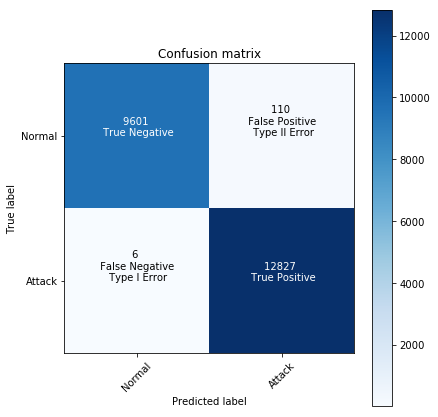

In [31]:
plot(actual_value = df.loc[:,'Actual'].values.astype(int),
     pred_value = df.loc[:,'Prediction'].values.astype(int))

In [32]:
df_.groupby(by="Actual").Actual.count()

Actual
0.0     9711
1.0    12833
Name: Actual, dtype: int64

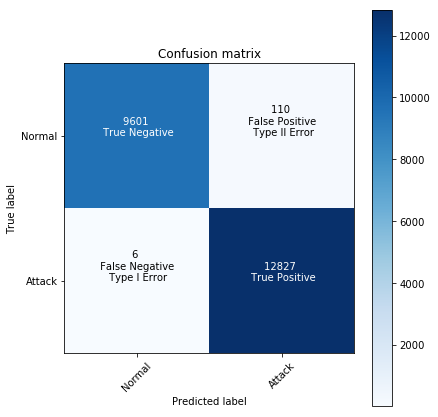

In [33]:
plot(actual_value = df_.loc[:,'Actual'].values.astype(int),
     pred_value = df_.loc[:,'Prediction'].values.astype(int))

In [34]:
from scipy import stats

def fn(x):
    #print(x)
    return stats.norm.interval(0.95, loc=x.f1_score.mean(), scale=x.f1_score.std())
psg.apply(fn)

no_of_features  hidden_layers
1               1                (0.908368939624, 0.942862285696)
                3                 (0.985690400269, 1.00773875175)
dtype: object